In [10]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

In [11]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2013-01-01'
end_date = '2024-01-01'

In [ ]:
data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("./Data/tickers.csv")

closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

closing_prices.tail(10)

[*********************100%***********************]  7 of 7 completed


Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.329193,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.764862,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089165,356.755829,49.402992,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724052,357.244354,49.507965,23.540001,253.179993
2023-12-29 00:00:00+00:00,147.410004,151.940002,49.585903,352.897461,49.507965,23.459999,248.479996


<Axes: >

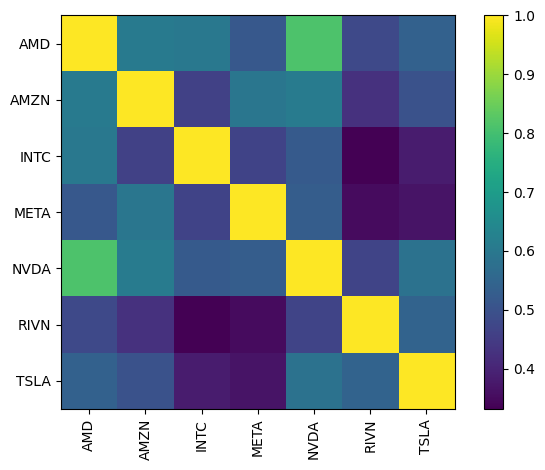

In [10]:
covariance_matrix = returns.cov()
plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [11]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


In [12]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)
delta = black_litterman.market_implied_risk_aversion(market_prices)

prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

market_caps
market_prices

[*********************100%***********************]  1 of 1 completed


Date
2013-01-02    108.388954
2013-01-03    108.291595
2013-01-04    108.745934
2013-01-07    108.453835
2013-01-08    108.129333
                 ...    
2023-12-22    431.015472
2023-12-26    432.807709
2023-12-27    433.599792
2023-12-28    433.669128
2023-12-29    432.510620
Name: Adj Close, Length: 2768, dtype: float64

In [ ]:
relative_views = np.array([0.20, 0.15, 0.10, -0.07]).reshape(-1, 1)

confidences = [0.2, 0.2, 0.2, 0.2]

picking_matrix = np.array([
    [1, 0, -1, 0, 0, 0, 0],  # TSLA - AMZN
    [0, 1, 0, -1, 0, 0, 0],  # NVDA - META
    [0, 0, 0, 1, 0, 0, -1],  # META - AMD
    [0, 0, 0, 0, 0, -1, 1]   # INTC - AMD
])

bl = BlackLittermanModel(
    cov_matrix=covariance_matrix, 
    pi=prior, 
    absolute_views=None, 
    Q=relative_views, 
    P=picking_matrix, 
    omega="idzorek", 
    view_confidences=confidences, 
    tau=0.025, 
    risk_aversion=delta
)

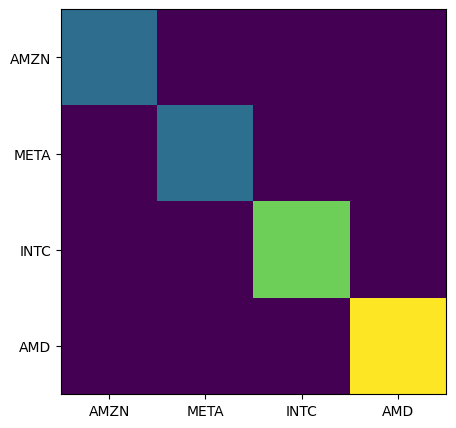

array([7.65875801e-05, 7.80082640e-05, 1.66030490e-04, 2.13560055e-04])

In [16]:
tickers_with_views = ["AMZN", "META", "INTC", "AMD"]

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(tickers_with_views)))
ax.set_yticks(np.arange(len(tickers_with_views)))

ax.set_xticklabels(tickers_with_views)
ax.set_yticklabels(tickers_with_views)
plt.show()

np.diag(bl.omega)

In [17]:
bl_returns = bl.bl_returns()
bl_returns

Ticker
AMD     0.056108
AMZN    0.043380
INTC    0.014922
META    0.020653
NVDA    0.047656
RIVN    0.048209
TSLA    0.025378
dtype: float64

In [18]:
relative_views_series = pd.Series(np.nan, index=tickers)
relative_views_series[:len(relative_views)] = relative_views.flatten()

returns_df = pd.DataFrame([prior, bl_returns, relative_views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.023122,0.056108,NaN
AMZN,0.022370,0.043380,0.10
INTC,0.021536,0.014922,NaN
META,0.022739,0.020653,-0.07
NVDA,0.023602,0.047656,0.15
RIVN,0.023290,0.048209,NaN
TSLA,0.023054,0.025378,0.20


<Axes: >

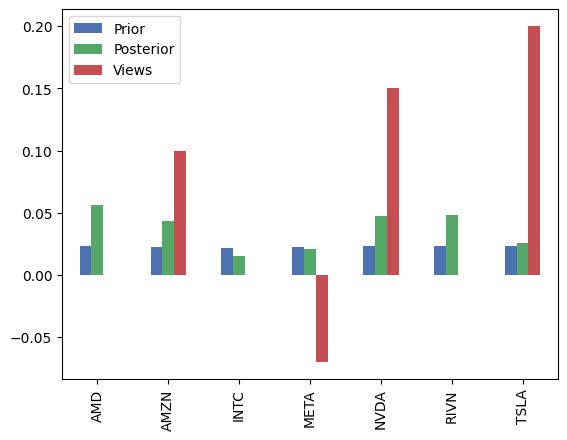

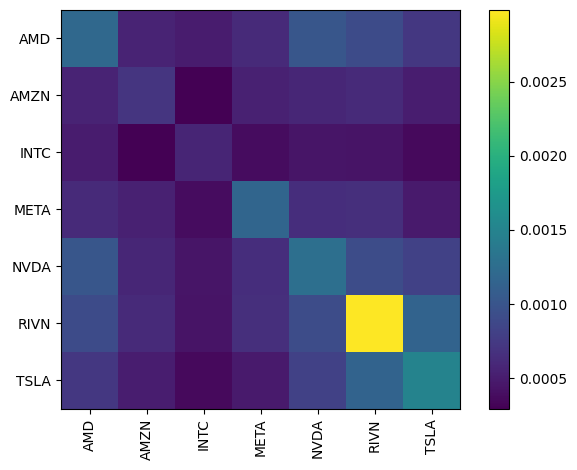

In [19]:
# visualisation of above
returns_df.plot.bar()

posterior_cov = bl.bl_cov()
plotting.plot_covariance(posterior_cov)

In [ ]:
ef = EfficientFrontier(bl_returns, posterior_cov)
# min_vol_weights = ef.min_volatility()
max_sharpe_weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('AMD', 0.60568),
             ('AMZN', 0.39432),
             ('INTC', 0.0),
             ('META', 0.0),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

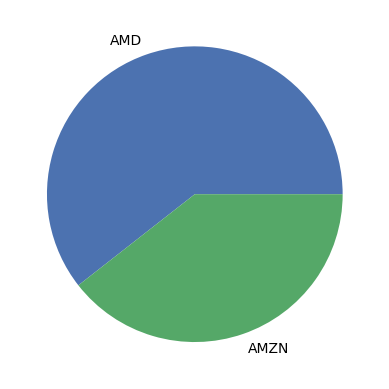

In [21]:
model_1_allocations = pd.Series(cleaned_weights).plot.pie()

In [22]:
ef.portfolio_performance(verbose=True)

Expected annual return: 5.1%
Annual volatility: 2.9%
Sharpe Ratio: 1.09


(0.05108899242240951, 0.02863144539460038, 1.0858338443602502)